In [1]:
!pip install -q shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 15.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import shap

In [3]:
# to import files from googledrive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
sample_size_dir = 'gdrive/My Drive/Sample size for NLP'

Mounted at /content/gdrive/


original

53081

51881

42731

41401

25000

5990

5849 - different file

4280

4019

2724


In [445]:
diagnosis = 'original'

#5849 had some formatting issues and blank rows, so clean verion is _JCedit

In [446]:
#df = pd.read_csv(sample_size_dir+'/data_jaya/'+diagnosis+'_combined_data_6000.csv')
#df = pd.read_csv(sample_size_dir+'/data_jaya/'+diagnosis+'_combined_data_6000_JCedit.csv')
df = pd.read_csv(sample_size_dir+'/Sample_Size_Saniya/12k_data_for_classifier.csv')
#df = pd.read_csv(sample_size_dir+'/data_jaya/'+diagnosis+'_combined_data_1000.csv')# TO DO
df.head(2)

,Unnamed: 0,subject_id,icd9_code,gender,dob,ethnicity,text,no_of_docs,label
0,0,1738,4019,F,2090-12-20 00:00:00,WHITE,CONDITION UPDATE\nD: PLEASE SEE CAREVUE FOR SP...,48,1
1,1,23055,4019,F,2044-10-15 00:00:00,UNKNOWN/NOT SPECIFIED,MSICU NSG ADMIT NOTE 1400-1900\n\n60 YO woman ...,50,1


In [447]:
len(df)

12000

In [448]:
df.rename(columns={'TEXT': 'text'}, inplace=True)

In [449]:
df['label'].value_counts()

,count
label,
1,6000
0,6000


In [450]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['text'])
y = df['label']

In [451]:
# using l1 lasso regularisation and liblinear solver to find optimal params for the model and is good with small datasets

lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear')
lasso_log_reg.fit(X, y)

LogisticRegression(penalty='l1', solver='liblinear')

how many in middle - number of almost 0 parameters words and number of high coeff words and compare with others of same size.

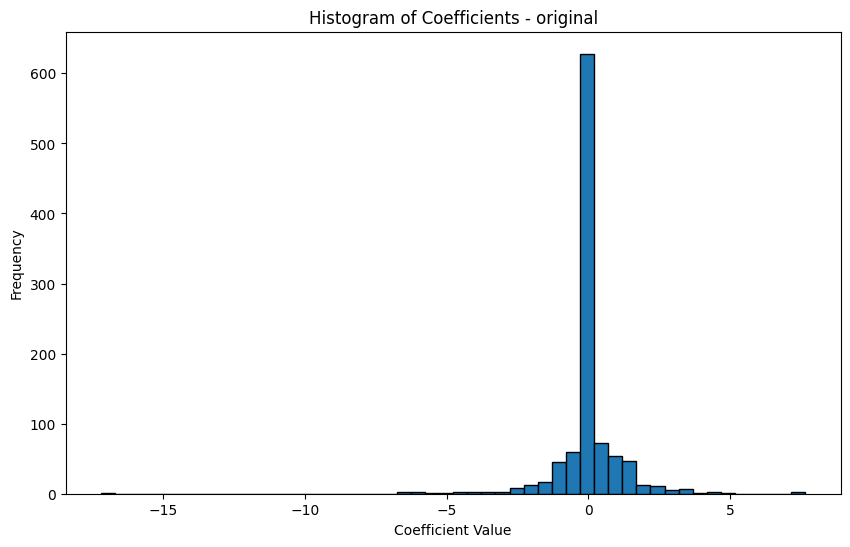

In [452]:
# analyse weights

coefficients = lasso_log_reg.coef_.flatten()

plt.figure(figsize=(10, 6))
plt.hist(coefficients, bins=50, edgecolor='k')
plt.title("Histogram of Coefficients - "+diagnosis)
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

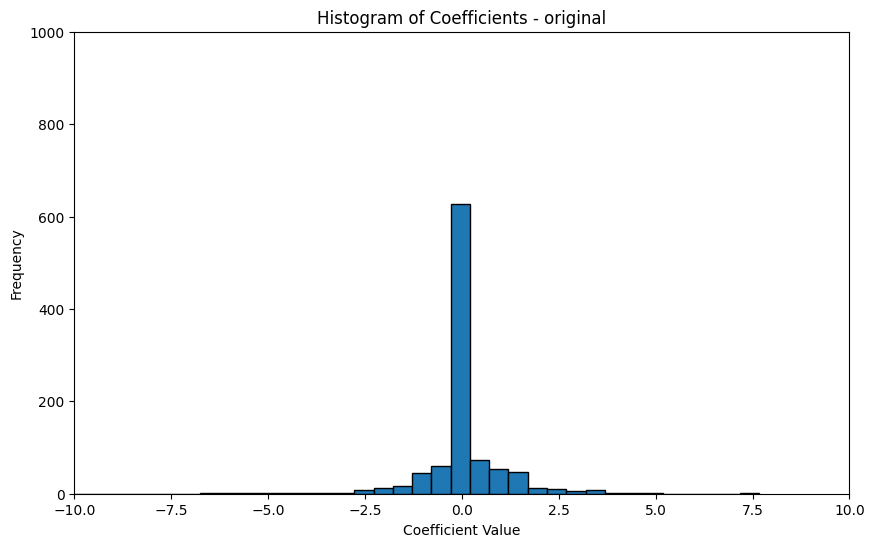

In [453]:
# analyse weights with limited axis

coefficients = lasso_log_reg.coef_.flatten()

plt.figure(figsize=(10, 6))
plt.hist(coefficients, bins=50, edgecolor='k')
plt.title("Histogram of Coefficients - "+diagnosis)
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.xlim(-10, 10)  # Set the x-axis limit from -10 to 10
plt.ylim(0, 1000)  # Set the y-axis limit from 0 to 1000
plt.show()

In [454]:
non_zero_coefs = np.sum(coefficients != 0)
print(f"Number of non-zero coefficients: {non_zero_coefs}")

Number of non-zero coefficients: 439


In [455]:
# Number of features with high weight

weights = lasso_log_reg.coef_.flatten()

high_weight_threshold = 0.1  # Example threshold
high_weight_features = np.sum(np.abs(weights) > high_weight_threshold)

print(f"Number of features with high weight: {high_weight_features}")
print(f"Total number of features: {len(weights)}")

Number of features with high weight: 408
Total number of features: 1000


**Number of non-zero coefficients:**

Original: 439

53081: 184

42731: 143

41401: 182

25000: 251

5990: 188

5849: 236

4280: 197

4019: 277

2724: 214

**Total Number of features:**

1000 for all

**Number of high weight features (over threshold of 0.1):**

Original: 408

53081: 167

42731: 133

41401: 174

25000: 222

5990: 170

5849: 223

4280: 181

4019: 249

2724: 195

In [456]:
print(X.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.18137114 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [457]:
'''
# SHAP - calculate the contribution of each feature to the model's prediction - this is on lasso logistic regression and not so good
# interventional perturbation - model predictions are adjusted based on the distribution of the other features. more accurate but computationally expensive - it tries to account for the interdependencies between features

explainer = shap.LinearExplainer(lasso_log_reg, X, feature_perturbation="interventional")
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())'''

'\n# SHAP - calculate the contribution of each feature to the model\'s prediction - this is on lasso logistic regression and not so good\n# interventional perturbation - model predictions are adjusted based on the distribution of the other features. more accurate but computationally expensive - it tries to account for the interdependencies between features\n\nexplainer = shap.LinearExplainer(lasso_log_reg, X, feature_perturbation="interventional")\nshap_values = explainer.shap_values(X)\n\nshap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())'

In [458]:
feature_names = vectorizer.get_feature_names_out()

print(feature_names)

['00' '000' '0000' ... 'zytec' 'zyvox' 'zyvoxx']


In [459]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

data = pd.DataFrame({"text": df_train["text"], "label": df_train["label"]})

In [460]:
import transformers

# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased").cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [461]:
explainer = shap.Explainer(pred)

In [462]:
feature_names = tfidf.get_feature_names_out()
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
sorted_coef_df = coef_df.sort_values(by='coefficient', ascending=False)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


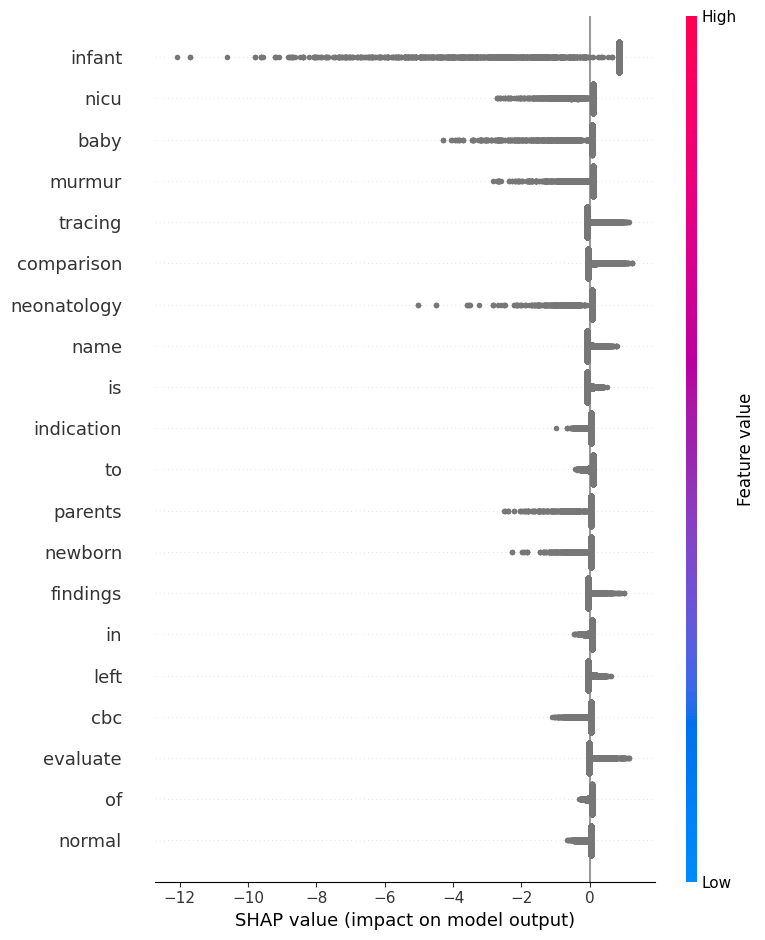

In [463]:
# SHAP

explainer = shap.LinearExplainer(lasso_log_reg, X, feature_perturbation="interventional")
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, features=X, feature_names=feature_names)


- how many in middle - number of almost 0 parameters words and number of high coeff words and compare with others of same size.